In [1]:
!pip install transformers datasets -q

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
dataset = load_dataset("ag_news")

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

MAX_LEN = 128

def tokenize(batch):
    return tokenizer(batch["text"],
                     padding="max_length",
                     truncation=True,
                     max_length=MAX_LEN)

dataset = dataset.map(tokenize, batched=True)
dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

train_loader = DataLoader(dataset["train"], batch_size=32, shuffle=True)
val_loader = DataLoader(dataset["test"], batch_size=32)

num_classes = 4

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [3]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim,
                            batch_first=True,
                            bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        output, _ = self.lstm(x)
        x = output[:, -1, :]
        x = self.dropout(x)
        return self.fc(x)

In [4]:
def train_model(model, train_loader, val_loader,
                lr=1e-3, weight_decay=1e-4, epochs=5):

    model.to(device)
    optimizer = optim.Adam(model.parameters(),
                           lr=lr,
                           weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float("inf")
    patience = 2
    trigger = 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0

        for batch in train_loader:
            inputs = batch["input_ids"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_losses.append(total_loss/len(train_loader))
        train_accs.append(correct/len(train_loader.dataset))

        model.eval()
        val_loss, correct = 0, 0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch["input_ids"].to(device)
                labels = batch["label"].to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()

        val_losses.append(val_loss/len(val_loader))
        val_accs.append(correct/len(val_loader.dataset))

        print(f"Epoch {epoch+1}: "
              f"Train Acc {train_accs[-1]:.4f}, "
              f"Val Acc {val_accs[-1]:.4f}")

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            trigger = 0
        else:
            trigger += 1
            if trigger >= patience:
                print("Early stopping triggered")
                break

    return train_losses, val_losses, train_accs, val_accs

In [5]:
vocab_size = tokenizer.vocab_size

model_lstm = LSTMClassifier(
    vocab_size=vocab_size,
    embed_dim=128,
    hidden_dim=128,
    num_classes=num_classes,
    dropout=0.3  # change to 0.1 / 0.5 for experiments
)

train_losses, val_losses, train_accs, val_accs = train_model(
    model_lstm,
    train_loader,
    val_loader,
    lr=1e-3,
    weight_decay=1e-4,
    epochs=5
)

Epoch 1: Train Acc 0.4526, Val Acc 0.8432
Epoch 2: Train Acc 0.8966, Val Acc 0.9045
Epoch 3: Train Acc 0.9159, Val Acc 0.9076
Epoch 4: Train Acc 0.9225, Val Acc 0.9150
Epoch 5: Train Acc 0.9287, Val Acc 0.9155


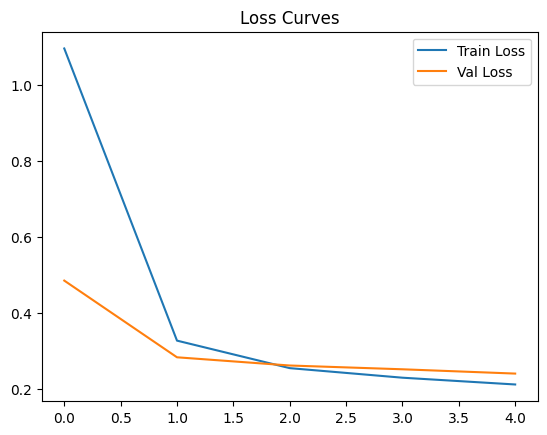

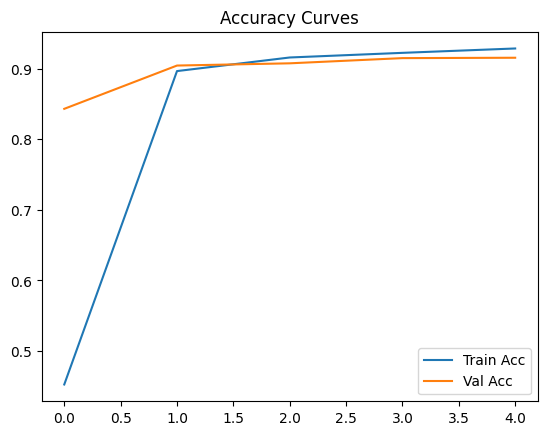

In [6]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy Curves")
plt.show()

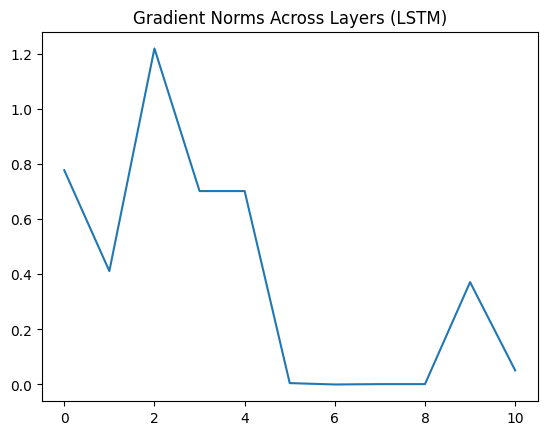

In [7]:
def plot_gradient_norms(model):
    norms = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            norms.append(param.grad.norm().item())

    plt.plot(norms)
    plt.title("Gradient Norms Across Layers (LSTM)")
    plt.show()

# Run one batch to collect gradients
model_lstm.train()
batch = next(iter(train_loader))
inputs = batch["input_ids"].to(device)
labels = batch["label"].to(device)

criterion = nn.CrossEntropyLoss()
outputs = model_lstm(inputs)
loss = criterion(outputs, labels)
loss.backward()

plot_gradient_norms(model_lstm)

In [8]:
model_bert = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_classes
).to(device)

optimizer = optim.AdamW(model_bert.parameters(), lr=2e-5)

for epoch in range(3):
    model_bert.train()
    for batch in train_loader:
        optimizer.zero_grad()

        outputs = model_bert(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device),
            labels=batch["label"].to(device)
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f"BERT Epoch {epoch+1} completed")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


BERT Epoch 1 completed
BERT Epoch 2 completed
BERT Epoch 3 completed


In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print("LSTM Parameters:", count_parameters(model_lstm))
print("BERT Parameters:", count_parameters(model_bert))

print("Final Train Acc:", train_accs[-1])
print("Final Val Acc:", val_accs[-1])
print("Overfitting Gap:",
      train_accs[-1] - val_accs[-1])

LSTM Parameters: 4172036
BERT Parameters: 109485316
Final Train Acc: 0.9286583333333334
Final Val Acc: 0.9155263157894736
Overfitting Gap: 0.01313201754385973
